# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Flux
using Plots
using StatsBase
using MLJ: confusion_matrix

include("../../lib.jl")

ENV["LINES"]=30;

In [2]:
mkdir("./Figures")

LoadError: IOError: mkdir: file already exists (EEXIST)

# Datasets

In [3]:
data = CSV.read("data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


In [4]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1,3.0,5,,,Int64
3,Left_Distance,3.0,1,3.0,5,,,Int64
4,Right_Weight,3.0,1,3.0,5,,,Int64
5,Right_Distance,3.0,1,3.0,5,,,Int64


Look at class labels to see if dataset is imbalanced

In [5]:
label_counts = countmap(data[:Class_Name])

Dict{String,Int64} with 3 entries:
  "B" => 49
  "L" => 288
  "R" => 288

In [6]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

Get data ready for training

In [7]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [8]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [9]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class_Name])) # gives 70:30 split

([595, 102, 55, 568, 425, 389, 146, 63, 372, 250  …  195, 500, 571, 533, 112, 396, 297, 106, 303, 261], [444, 144, 546, 43, 19, 173, 365, 423, 27, 218  …  293, 614, 90, 471, 13, 134, 296, 79, 395, 415])

In [10]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0776255707762557
 0.4611872146118721
 0.4611872146118721

In [11]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.08021390374331551
 0.45989304812834225
 0.45989304812834225

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [12]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [13]:
@load NeuralNetworkClassifier verbosity=2

import MLJFlux 

┌ Info: Loading into module "Main": 
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/mUBFt/src/loading.jl:70


✔
import MLJFlux ✔


NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @411

## Neural networks
* Use favorite kind of network and training algorithm. 
* You may use networks of nodes with as many layers as you like and any activation function you see fit.

1. https://github.com/alan-turing-institute/MLJFlux.jl/blob/master/examples/boston.ipynb
1. https://github.com/alan-turing-institute/MLJFlux.jl
1. https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/

In [14]:
# Define a custom network
mutable struct CustomNN <:MLJFlux.Builder
    n1 ::Int
end

In [15]:
function MLJFlux.build(nn::CustomNN, n_in, n_out)
    return Chain(
        Flux.Dense(n_in, nn.n1, σ),
        Flux.Dense(nn.n1, n_out, σ)
    )
end

In [16]:
layer1 = 80

80

In [17]:
batch_sz = 32;

In [18]:
max_epochs = 3000;

### No-preprocessing

In [19]:
nn = NeuralNetworkClassifier(builder=CustomNN(layer1))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 80),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @500

In [20]:
Net = machine(nn, X, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @862 trained 0 times.
  args: 
    1:	Source @983 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @110 ⏎ `AbstractArray{Multiclass{3},1}`


In [21]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.1

0.1

In [22]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @862.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Loss is 1.04
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9919
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.967
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9534
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9451
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9392
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.934
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9288
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9229
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.916
└ 

Machine{NeuralNetworkClassifier{CustomNN,…}} @862 trained 1 time.
  args: 
    1:	Source @983 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @110 ⏎ `AbstractArray{Multiclass{3},1}`


In [23]:
nn.optimiser.eta = nn.optimiser.eta / 3
nn.epochs = nn.epochs + 40

100

In [24]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{CustomNN,…}} @862.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:320
┌ Info: Loss is 0.6887
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6882
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6878
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6874
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6871
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6867
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6864
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6861
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6857
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.68

Machine{NeuralNetworkClassifier{CustomNN,…}} @862 trained 2 times.
  args: 
    1:	Source @983 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @110 ⏎ `AbstractArray{Multiclass{3},1}`


In [25]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:06


┌───────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                       │
├───────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy │ 0.718         │ Float32[0.758, 0.718, 0.715, 0.691, 0.73, 0.696] │
│ acc           │ 0.872         │ [0.81, 0.885, 0.885, 0.913, 0.856, 0.885]        │
└───────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.562, 0.711, ..., 0.697], [0.626, 0.709, ..., 0.555], [0.748, 0.618, ..., 0.578], [0.609, 0.721, ..., 0.706], [0.732, 0.558, ..., 1.48], [0.605, 0.72, ..., 0.992]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [26]:
fitted_params(Net)

(chain = Chain(Chain(Dense(4, 80, σ), Dense(80, 3, σ)), softmax),)

In [27]:
report(Net)

(training_losses = Any[1.0804945f0, 1.0548455f0, 1.0316869f0, 1.0116435f0, 0.99555475f0, 0.98349255f0, 0.9747008f0, 0.9681988f0, 0.9631934f0, 0.9591464f0  …  0.7286847f0, 0.72776365f0, 0.7268638f0, 0.7259846f0, 0.7251253f0, 0.72428507f0, 0.72346354f0, 0.72266f0, 0.7218739f0, 0.72110444f0],)

### Learning Curve

In [28]:
Net.model.epochs = max_epochs
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @862.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:09


Machine{NeuralNetworkClassifier{CustomNN,…}} @862 trained 9 times.
  args: 
    1:	Source @983 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @110 ⏎ `AbstractArray{Multiclass{3},1}`


In [29]:
nn_acc = evaluate!(Net, resampling=Holdout(), measure=[cross_entropy, acc], verbosity=1)

┌───────────────┬───────────────┬────────────────┐
│ _.measure     │ _.measurement │ _.per_fold     │
├───────────────┼───────────────┼────────────────┤
│ cross_entropy │ 0.617         │ Float32[0.617] │
│ acc           │ 0.914         │ [0.914]        │
└───────────────┴───────────────┴────────────────┘
_.per_observation = [[[1.25, 0.561, ..., 1.28]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [30]:
vals = collect(0:5:max_epochs)
r = range(nn, :epochs, lower=1, upper=max_epochs, scale=:log10)

MLJBase.NumericRange(Int64, :epochs, ... )

In [31]:
curve = MLJ.learning_curve(Net, 
                        range=r, 
                        resampling=Holdout(fraction_train=0.7), 
#                         resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUProcesses()
)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @384.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 28 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 28 metamodels: 100%[=========================] Time: 0:00:09


(parameter_name = "epochs",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 5, 7, 9, 12, 16, 21  …  250, 330, 434, 572, 754, 994, 1310, 1727, 2276, 3000],
 measurements = [1.0450003147125244, 1.0478273630142212, 1.0534253120422363, 1.0615839958190918, 1.0719302892684937, 1.0858654975891113, 1.1018987894058228, 1.1147055625915527, 1.113755226135254, 1.094984769821167  …  0.6780390739440918, 0.6678590178489685, 0.661782443523407, 0.657189667224884, 0.6536226868629456, 0.6516215205192566, 0.6505971550941467, 0.6464105844497681, 0.6312357187271118, 0.6163867115974426],)

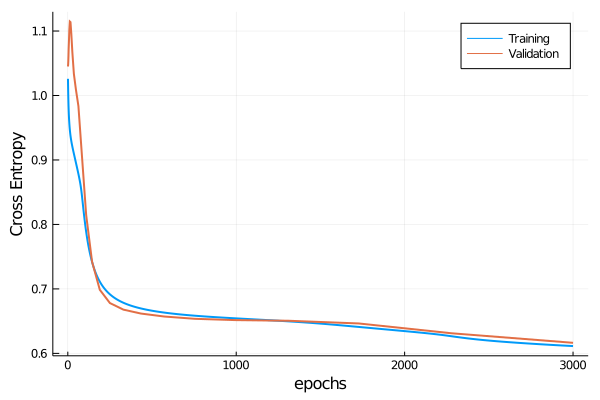

In [32]:
plot(Net.report.training_losses, label="Training", lw=2)
plot!(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)


In [33]:
a = round(nn.optimiser.eta, digits=5)
b = round(minimum(curve.measurements), digits=5)
best_epochs = curve.parameter_values[argmin(curve.measurements)]
a,b, best_epochs

(0.00033, 0.61639, 3000)

### GridSearch for Hidden Layer Size 1

In [34]:
Net = machine(nn, X, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @443 trained 0 times.
  args: 
    1:	Source @612 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @668 ⏎ `AbstractArray{Multiclass{3},1}`


In [35]:
param1 = :epochs
param2 = :(builder.n1)

r1 = range(nn, param1, lower=10, upper=max_epochs, scale=:log10)
# r1 = range(nn, param1, lower=1, upper=100, scale=:linear)
r2 = range(nn, param2, lower=1, upper=150, scale=:linear)

MLJBase.NumericRange(Int64, :(builder.n1), ... )

In [36]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=144),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @020,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.0003333333333333333, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 3000,
            batch_size = 32,
            lambda = 0.1,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 144,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @722, NumericRange{Int64,…} @723],
    train_best = true,
    repeats = 1,
    

In [37]:
self_tuning_nn = machine(self_tuning_nn_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @320 trained 0 times.
  args: 
    1:	Source @951 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @103 ⏎ `AbstractArray{Multiclass{3},1}`


In [38]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @320.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 144 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 144 metamodels: 100%[=========================] Time: 0:02:57


Machine{ProbabilisticTunedModel{Grid,…}} @320 trained 1 time.
  args: 
    1:	Source @951 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @103 ⏎ `AbstractArray{Multiclass{3},1}`


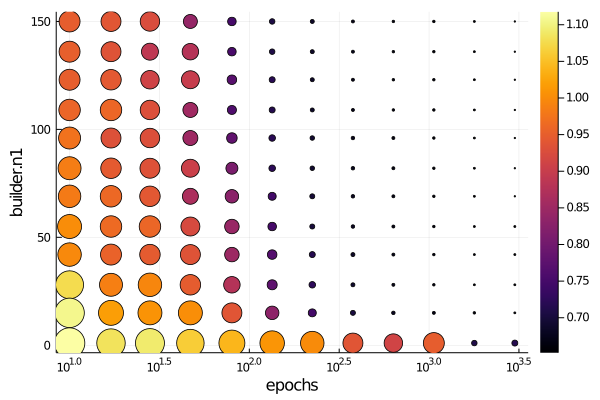

In [39]:
plot(self_tuning_nn)

In [40]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @141,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 123, σ), Dense(123, 3, σ)), softmax),),)

In [41]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 123),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.0003333333333333333, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 3000,
    batch_size = 32,
    lambda = 0.1,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @141

In [42]:
best_loss = z.report.best_result.measurement[1]

0.65224516f0

In [43]:
best_n1 = best.best_model.builder.n1

123

### GridSearch for Learning Rate

In [44]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 123),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @036

In [45]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [46]:
Net = machine(nn, X, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @523 trained 0 times.
  args: 
    1:	Source @490 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @957 ⏎ `AbstractArray{Multiclass{3},1}`


In [47]:
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @523.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:00


Machine{NeuralNetworkClassifier{CustomNN,…}} @523 trained 1 time.
  args: 
    1:	Source @490 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @957 ⏎ `AbstractArray{Multiclass{3},1}`


In [48]:
param1 = :epochs
param2 = :(optimiser.eta)

r1 = range(nn, param1, lower=10, upper=max_epochs, scale=:linear)
r2 = range(nn, param2, lower=0.0001, upper=10^-1, scale=:log10)

MLJBase.NumericRange(Float64, :(optimiser.eta), ... )

In [49]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=100),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUProcesses(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @250,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 32,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @556, NumericRange{Float64,…} @794],
    train_best = true,
    repeats = 1,
    n = nothing

In [50]:
self_tuning_nn = machine(self_tuning_nn_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @174 trained 0 times.
  args: 
    1:	Source @854 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @649 ⏎ `AbstractArray{Multiclass{3},1}`


In [51]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @174.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 100 metamodels: 100%[=========================] Time: 0:04:08


Machine{ProbabilisticTunedModel{Grid,…}} @174 trained 1 time.
  args: 
    1:	Source @854 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @649 ⏎ `AbstractArray{Multiclass{3},1}`


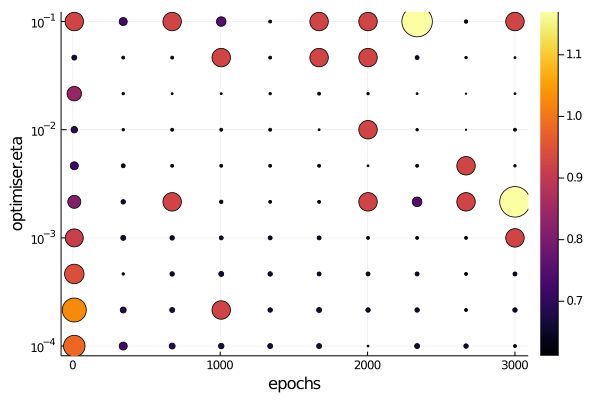

In [52]:
plot(self_tuning_nn)

In [53]:
fn = "Figures/NN_MCC_LR"
png(replace(fn,'.' => ','))

In [54]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @476,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 123, σ), Dense(123, 3, σ)), softmax),),)

In [55]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 123),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.021544346900318832, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 2668,
    batch_size = 32,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @476

In [56]:
best_loss = z.report.best_result.measurement[1]

0.61152774f0

In [57]:
best_eta = round(best.best_model.optimiser.eta, digits=5)

0.02154

In [58]:
best_epochs = best.best_model.epochs

2668

### GridSearch for Regularization

In [59]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 123),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @271

In [60]:
nn.optimiser.eta = best_eta
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [61]:
Net = machine(nn, X, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @874 trained 0 times.
  args: 
    1:	Source @462 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @304 ⏎ `AbstractArray{Multiclass{3},1}`


In [62]:
param1 = :epochs
param2 = :lambda

r1 = range(nn, param1, lower=100, upper=max_epochs, scale=:linear)
r2 = range(nn, param2, lower=0.0001, upper=1, scale=:log10)

MLJBase.NumericRange(Float64, :lambda, ... )

In [63]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=100),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUProcesses(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @930,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.02154, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 32,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @551, NumericRange{Float64,…} @889],
    train_best = true,
    repeats = 1,
    n = nothi

In [64]:
self_tuning_nn = machine(self_tuning_nn_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @257 trained 0 times.
  args: 
    1:	Source @223 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @448 ⏎ `AbstractArray{Multiclass{3},1}`


In [65]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @257.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 100 metamodels: 100%[=========================] Time: 0:06:09m


Machine{ProbabilisticTunedModel{Grid,…}} @257 trained 1 time.
  args: 
    1:	Source @223 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @448 ⏎ `AbstractArray{Multiclass{3},1}`


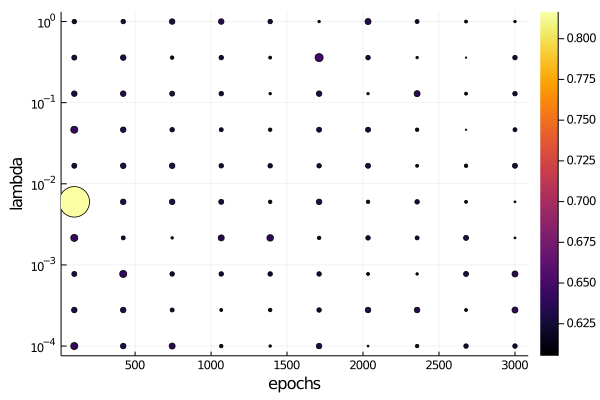

In [66]:
plot(self_tuning_nn)

In [67]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @114,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 123, σ), Dense(123, 3, σ)), softmax),),)

In [68]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 123),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.02154, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 2678,
    batch_size = 32,
    lambda = 0.046415888336127795,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @114

In [69]:
best_loss = z.report.best_result.measurement[1]

0.6053234f0

In [70]:
best_lambda = best.best_model.lambda

0.046415888336127795

### Learning Curve

In [71]:
lc_model = NeuralNetworkClassifier(builder=CustomNN(best_n1)) #70
lc_model.optimiser.eta = best_eta; #0.003
lc_model.lambda = best_lambda #0.01
lc_model.epochs = best_epochs #130
lc_model.batch_size = batch_sz #32
lc_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 123),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.02154, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 2668,
    batch_size = 32,
    lambda = 0.046415888336127795,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @425

In [72]:
data_schedule, training_losses, valid_losses = learn_curve(lc_model, X[train,:], y[train], acc, step=10)

(d, train_metric, valid_metric) = (10, 0.9, 0.8295454545454546)
(d, train_metric, valid_metric) = (20, 0.95, 0.8409090909090909)
(d, train_metric, valid_metric) = (30, 0.9, 0.875)
(d, train_metric, valid_metric) = (40, 0.875, 0.8977272727272727)
(d, train_metric, valid_metric) = (50, 0.88, 0.8977272727272727)
(d, train_metric, valid_metric) = (60, 0.8833333333333333, 0.9204545454545454)
(d, train_metric, valid_metric) = (70, 0.9, 0.8977272727272727)
(d, train_metric, valid_metric) = (80, 0.8625, 0.9090909090909091)
(d, train_metric, valid_metric) = (90, 0.8555555555555555, 0.8977272727272727)
(d, train_metric, valid_metric) = (100, 0.88, 0.9318181818181818)
(d, train_metric, valid_metric) = (110, 0.8909090909090909, 0.9318181818181818)
(d, train_metric, valid_metric) = (120, 0.8916666666666667, 0.9318181818181818)
(d, train_metric, valid_metric) = (130, 0.9, 0.9318181818181818)
(d, train_metric, valid_metric) = (140, 0.9, 0.9431818181818182)
(d, train_metric, valid_metric) = (150, 0.9,

(10:10:350, Any[0.9, 0.95, 0.9, 0.875, 0.88, 0.8833333333333333, 0.9, 0.8625, 0.8555555555555555, 0.88  …  0.9461538461538461, 0.9185185185185185, 0.9107142857142857, 0.9172413793103448, 0.9266666666666666, 0.9774193548387097, 0.971875, 0.9515151515151515, 0.9205882352941176, 0.9285714285714286], Any[0.8295454545454546, 0.8409090909090909, 0.875, 0.8977272727272727, 0.8977272727272727, 0.9204545454545454, 0.8977272727272727, 0.9090909090909091, 0.8977272727272727, 0.9318181818181818  …  0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818, 0.9431818181818182, 0.9431818181818182, 0.9318181818181818, 0.9318181818181818, 0.9318181818181818])

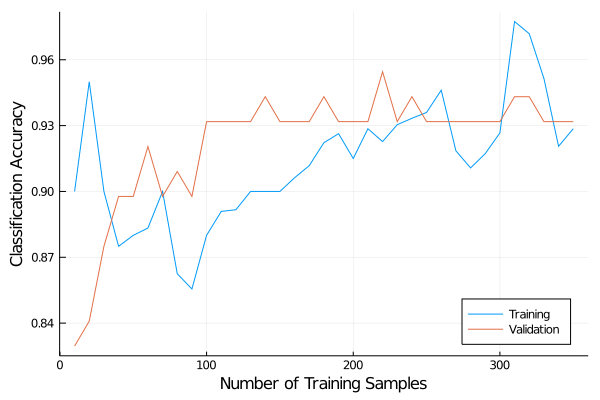

In [73]:
plot(data_schedule, training_losses, label="Training", legend=:bottomright)
plot!(data_schedule, valid_losses, label="Validation")
xlabel!("Number of Training Samples")
ylabel!("Classification Accuracy")

In [74]:
png("Figures/NN_LC")

#### Learning Curve

In [98]:
Net = machine(lc_model, X, y)
Net.model.epochs = max_epochs
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @819.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:12


Machine{NeuralNetworkClassifier{CustomNN,…}} @819 trained 1 time.
  args: 
    1:	Source @372 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @813 ⏎ `AbstractArray{Multiclass{3},1}`


In [99]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:01:25


┌───────────────┬───────────────┬───────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                        │
├───────────────┼───────────────┼───────────────────────────────────────────────────┤
│ cross_entropy │ 0.599         │ Float32[0.618, 0.557, 0.607, 0.604, 0.601, 0.604] │
│ acc           │ 0.946         │ [0.924, 1.0, 0.923, 0.913, 0.952, 0.962]          │
└───────────────┴───────────────┴───────────────────────────────────────────────────┘
_.per_observation = [[[0.551, 0.551, ..., 0.562], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [100]:
r = range(nn, :epochs, lower=1, upper=max_epochs, scale=:linear)

MLJBase.NumericRange(Int64, :epochs, ... )

In [101]:
curve = MLJ.learning_curve(Net, 
                        range=r, 
#                         resampling=Holdout(fraction_train=0.7), 
                        resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUProcesses(),
                        resolution=100
)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @436.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 100 metamodels: 100%[=========================] Time: 0:38:39


(parameter_name = "epochs",
 parameter_scale = :linear,
 parameter_values = [1, 31, 62, 92, 122, 152, 183, 213, 243, 274  …  2727, 2758, 2788, 2818, 2849, 2879, 2909, 2939, 2970, 3000],
 measurements = [1.1341290473937988, 1.074521541595459, 0.9001859426498413, 0.9454291462898254, 0.8132379651069641, 0.7280151844024658, 0.7824437022209167, 0.7777256965637207, 0.7242764234542847, 0.7375158071517944  …  0.6661814451217651, 0.7769949436187744, 0.6910997033119202, 0.6869031190872192, 0.7337479591369629, 0.6954826712608337, 0.8659523725509644, 0.6933438777923584, 0.7777193784713745, 0.7045760750770569],)

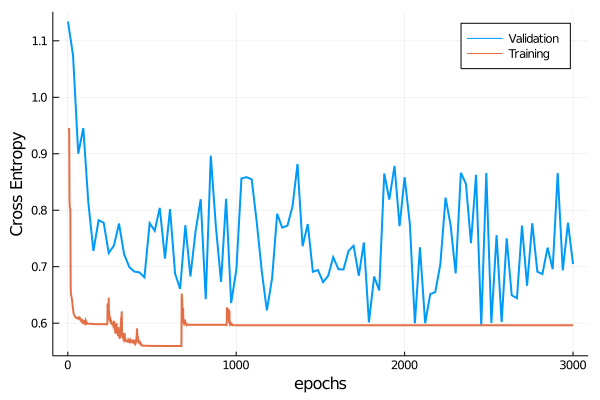

In [102]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
plot!(Net.report.training_losses, label="Training", lw=2)

In [103]:
best_epochs = curve.parameter_values[argmin(curve.measurements)]

2455

In [104]:
png("Figures/NN_LC_iterations")

# Final Results

In [82]:
final_model = NeuralNetworkClassifier(builder=CustomNN(best_n1))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 123),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @280

In [83]:
final_model.optimiser.eta = lc_model.optimiser.eta = best_eta;
final_model.batch_size = batch_sz
final_model.lambda = best_lambda
final_model.epochs = max_epochs

3000

### Test Performance

In [84]:
Final_Net = machine(final_model, X, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @217 trained 0 times.
  args: 
    1:	Source @842 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @886 ⏎ `AbstractArray{Multiclass{3},1}`


In [85]:
fit!(Final_Net, rows=train, force=true, verbosity=1)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @217.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:12


Machine{NeuralNetworkClassifier{CustomNN,…}} @217 trained 1 time.
  args: 
    1:	Source @842 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @886 ⏎ `AbstractArray{Multiclass{3},1}`


In [86]:
nn_acc = evaluate!(Final_Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:01:26


┌───────────────┬───────────────┬───────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                        │
├───────────────┼───────────────┼───────────────────────────────────────────────────┤
│ cross_entropy │ 0.589         │ Float32[0.572, 0.566, 0.562, 0.618, 0.615, 0.599] │
│ acc           │ 0.957         │ [0.981, 0.99, 0.99, 0.923, 0.913, 0.942]          │
└───────────────┴───────────────┴───────────────────────────────────────────────────┘
_.per_observation = [[[0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 1.02], [1.09, 0.551, ..., 0.551], [1.1, 1.1, ..., 0.551]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [87]:
ŷ = MLJ.predict(Final_Net, X[test,:]);

In [88]:
cross_entropy(ŷ, y[test]) |> mean

0.6010613f0

In [89]:
acc(ŷ, y[test])

0.93048128342246

In [90]:
c = confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │      3      │      0      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      7      │     85      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      5      │      1      │     86      │
└─────────────┴─────────────┴─────────────┴─────────────┘


In [105]:
1/(86)

0.011627906976744186

In [107]:
(7+5)/(7+5+3)

0.8

In [95]:
batch_sz

32

In [96]:
best_eta

0.02154

In [97]:
best_epochs

467